In [1]:
"""
jupyter notebook used for classification

author: Anton Thieme <anton@thiemenet.de>
"""

'\njupyter notebook used for classification\n\nauthor: Anton Thieme <anton@thiemenet.de>\n'

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import itertools
import math
import scienceplots

from scipy import stats
from scipy.optimize import curve_fit, fmin_slsqp
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, recall_score, precision_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.decomposition import PCA
from matplotlib.patches import Patch
from scipy.signal import argrelextrema, find_peaks
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.tree import export_graphviz
from sklearn.preprocessing import StandardScaler
from joblib import dump, load
from pathlib import Path

from Analysis.Auxiliary import *
from Figures.Kinetics import *

In [2]:
# DEFINE STATIC VARIABLES

plt.style.use(['science', 'no-latex', 'nature'])
plt.rcParams['svg.fonttype'] = 'none'

# set path to training dataset
PATH_TRAIN_15h = Path("./data/Training")

# set paths to admix and mixed datasets
PATH_ADMIX = Path("./data/Admix")

MT_SETS = []
WT_SETS = []
       
for folder in os.listdir(PATH_TRAIN_15h):
    
    if folder.find('MT') > 0:
        MT_SETS.append(folder[folder.find('_')+1:])
    elif folder.find('WT') > 0:
        WT_SETS.append(folder[folder.find('_')+1:])
    else:
        print('unclear training dataset found: {}'.format(folder))
        
print(MT_SETS)
print(WT_SETS)

EDGE_CUTOFF = 0.05
LABEL_FRAME_5h = 139
LABEL_FRAME_15h = 91
CLASSIFY_FRAME_15h = 13 #2h
MIN_FRAME = 3
N_CLASS_MEMBERS = 15000
NEG_PROB_CUTOFF = 1e-500

FEATURES_NORM = ['feat_fq_delta_final', 'feat_fq_delta_max', 'feat_fq_delta_avg', 'feat_fq_delta_area_final', 'feat_fq_delta_velocity_final',
       'feat_fq_delta_velocity_max', 'feat_fq_delta_velocity_min',
       'feat_fq_delta_velocity_avg']

FEATURES_ORIG = ['feat_fq_delta_tp_max',
       'feat_fq_delta_tp_min', 'feat_fq_delta_tp_avg', 'feat_fq_delta_velocity_tp_max',
       'feat_fq_delta_velocity_tp_min', 'feat_fq_delta_velocity_tp_avg', 'feat_tp_start_active']

['20230305_MT_24h_50fM', '20230320_MT_24h_50fM', '20230405_FKS1_Admix_MT_50fM', '20230406_FKS1_Admix_MT_10fM', '20230417_MT_50fM', '20230417_MT_50fM_2']
['20230305_FKS1_WT_CalCurve_5_50fM', '20230320_FKS1_WT_CalCurve_6_50fM', '20230324_FKS1_WT_CalCurve_1_500aM', '20230324_FKS1_WT_CalCurve_1_50aM', '20230324_FKS1_WT_CalCurve_1_5fM', '20230325_FKS1_WT_CalCurve_2_25aM', '20230325_FKS1_WT_CalCurve_2_500aM', '20230325_FKS1_WT_CalCurve_2_5fM', '20230326_FKS1_WT_CalCurve_3_25aM', '20230326_FKS1_WT_CalCurve_3_500aM', '20230326_FKS1_WT_CalCurve_3_50aM', '20230326_FKS1_WT_CalCurve_3_5fM', '20230328_FKS1_WT_CalCurve_4_50aM', '20230328_FKS1_WT_CalCurve_4_50fM', '20230417_WT_50fM', '20230417_WT_50fM_2']


#####
[1866.31479785]
[160841.43073834]
20230305_FKS1_WT_CalCurve_5_50fM


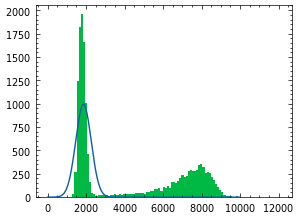

[5.77535261e-06 1.99588674e-08 1.36171748e-21 ... 7.11363899e-14
 1.25141217e-24 3.98419678e-56]
#####
[1973.46257579]
[72009.41194828]
20230305_MT_24h_50fM


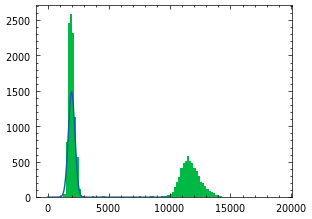

[6.49477841e-09 2.92481043e-43 6.13688681e-03 ... 5.09566897e-06
 6.38186613e-03 0.00000000e+00]
#####
[3847.9454817]
[414124.02321899]
20230320_FKS1_WT_CalCurve_6_50fM


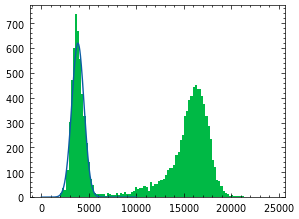

[3.95678429e-014 0.00000000e+000 0.00000000e+000 ... 0.00000000e+000
 2.31433735e-277 1.36856184e-321]
#####
[3460.70777526]
[169327.68276036]
20230320_MT_24h_50fM


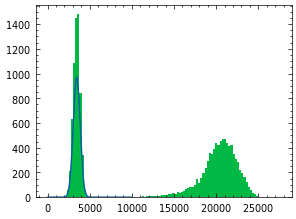

[0.00000000e+000 0.00000000e+000 5.60039515e-004 ... 0.00000000e+000
 0.00000000e+000 1.09823176e-144]
#####
[2526.1021388]
[13876.35606037]
20230324_FKS1_WT_CalCurve_1_500aM


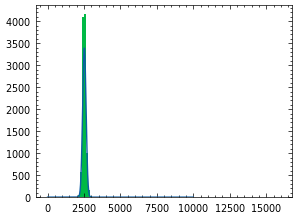

[1.27730035e-195 8.40710127e-067 7.28910087e-039 ... 1.14395209e-010
 1.21626568e-037 4.13696508e-059]
#####
[2802.77226199]
[23765.43118419]
20230324_FKS1_WT_CalCurve_1_50aM


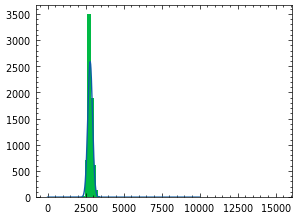

[1.60735627e-009 1.17127210e-118 7.89482270e-009 ... 9.77070397e-004
 3.27434219e-311 0.00000000e+000]
#####
[2662.23959905]
[85935.07186954]
20230324_FKS1_WT_CalCurve_1_5fM


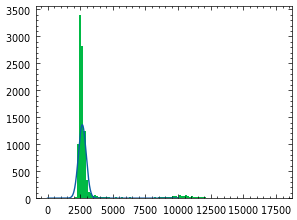

[1.07166822e-53 3.64809511e-85 6.11303667e-24 ... 1.14930983e-02
 1.48976949e-05 2.42745702e-07]
#####
[2062.44260546]
[22744.76883889]
20230325_FKS1_WT_CalCurve_2_25aM


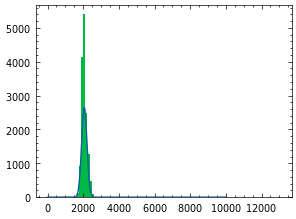

[1.74327360e-184 1.18027390e-276 4.61127337e-103 ... 1.59188497e-027
 3.87501450e-010 3.17517106e-005]
#####
[2101.90836191]
[17603.38115461]
20230325_FKS1_WT_CalCurve_2_500aM


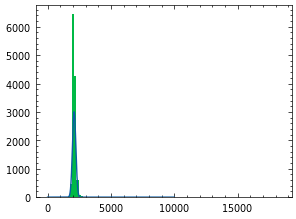

[6.66531055e-89 1.14158152e-13 4.60561277e-05 ... 1.12192037e-02
 2.15187198e-03 2.09935228e-07]
#####
[2634.9161245]
[30889.92855193]
20230325_FKS1_WT_CalCurve_2_5fM


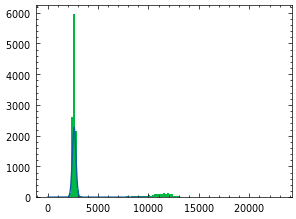

[1.48140152e-32 0.00000000e+00 2.78891624e-37 ... 5.73934070e-03
 3.68812652e-07 3.16854688e-37]
#####
[2269.39705149]
[25913.88253696]
20230326_FKS1_WT_CalCurve_3_25aM


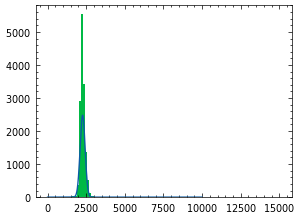

[5.37141403e-71 1.55899075e-44 3.70888036e-50 ... 2.05443112e-02
 5.98671740e-30 3.35365086e-80]
#####
[2112.02534025]
[35791.00257595]
20230326_FKS1_WT_CalCurve_3_500aM


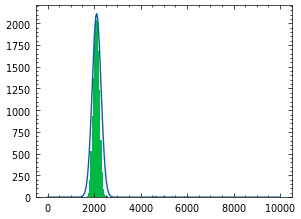

[9.73153245e-028 1.18504652e-003 4.19330957e-015 ... 2.57065341e-039
 1.60913671e-133 4.95743826e-085]
#####
[2252.17148396]
[33101.21388877]
20230326_FKS1_WT_CalCurve_3_50aM


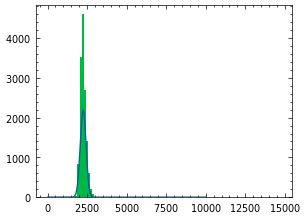

[8.42792447e-096 5.21978791e-027 2.01812411e-085 ... 8.60081256e-043
 7.18459849e-153 1.18991334e-093]
#####
[2401.17622679]
[215907.78942309]
20230326_FKS1_WT_CalCurve_3_5fM


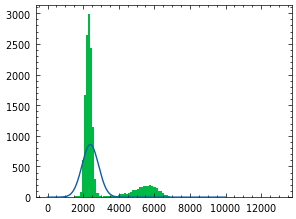

[0.00000000e+00 9.66368478e-07 1.80959930e-11 ... 4.88569890e-07
 2.83699196e-04 1.28494225e-03]
#####
[2641.85139879]
[28617.0847114]
20230328_FKS1_WT_CalCurve_4_50aM


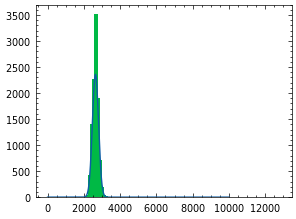

[6.38808412e-047 6.68181358e-003 4.59372360e-055 ... 7.14871378e-023
 2.81871064e-039 3.30952321e-103]
#####
[3193.19459646]
[142117.27707323]
20230328_FKS1_WT_CalCurve_4_50fM


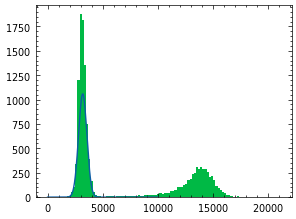

[0.00000000e+00 9.90641654e-33 4.50211138e-04 ... 0.00000000e+00
 1.89504226e-09 3.73190010e-32]
#####
[5431.48052225]
[658472.30233705]
20230405_FKS1_Admix_MT_50fM


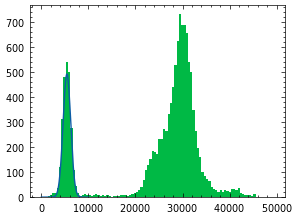

[1.74238594e-164 9.20819048e-130 8.51208936e-206 ... 0.00000000e+000
 0.00000000e+000 0.00000000e+000]
#####
[2378.51553651]
[80309.01377932]
20230406_FKS1_Admix_MT_10fM


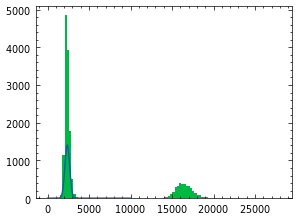

[4.51663106e-075 5.95475740e-182 0.00000000e+000 ... 0.00000000e+000
 2.54424195e-027 3.09443190e-003]
#####
[5085.72360382]
[402275.9688743]
20230417_MT_50fM


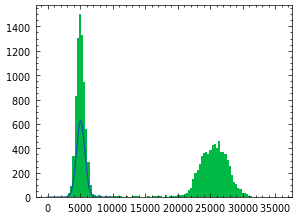

[0.00000000e+00 1.58174370e-02 4.66187390e-29 ... 0.00000000e+00
 0.00000000e+00 2.40750434e-06]
#####
[4212.68721183]
[208860.08406243]
20230417_MT_50fM_2


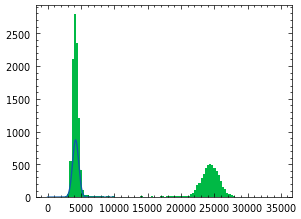

[3.36804969e-058 0.00000000e+000 5.76457474e-162 ... 0.00000000e+000
 5.05167110e-011 5.29776301e-062]
#####
[4476.85737711]
[344123.90270968]
20230417_WT_50fM


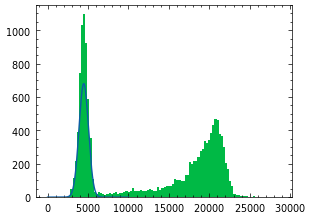

[0. 0. 0. ... 0. 0. 0.]
#####
[4480.66366288]
[309227.3966805]
20230417_WT_50fM_2


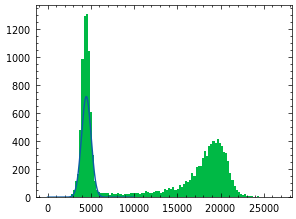

[8.49182404e-072 1.12830241e-046 0.00000000e+000 ... 0.00000000e+000
 2.20860457e-101 0.00000000e+000]


In [3]:
#################### GET CLASSIFIER ######################

# LOAD LABELLING DATASET AND TRAINING DATASET
df_label = batch_load_and_combine(PATH_TRAIN_15h, 'features_{}.csv'.format(LABEL_FRAME_15h))
df_train = batch_load_and_combine(PATH_TRAIN_15h, 'features_{}.csv'.format(CLASSIFY_FRAME_15h))

# REMOVE OUTLIERS
df_label = clean(df_label, z_roxInitial_exclude=2.0, z_fqInitial_exclude=2.5, frac_edge_exclude=0.05, dropna=True)
df_train = clean(df_train, z_roxInitial_exclude=2.0, z_fqInitial_exclude=2.5, frac_edge_exclude=0.05, dropna=True)

# LABEL CLUSTERS IN THE LABEL DATASET AND COPY LABELS INTO TRAINING DATASET
df_label, mus = labelNeg_thresh(df_label, 'feat_fq_delta_max', 2500, 2500, 10000)
for ii, set in enumerate(df_label['set'].unique()):
    if set in MT_SETS:
        df_label.loc[(df_label['set'] == set) & (df_label['prob'] <= NEG_PROB_CUTOFF), 'cluster'] = 'MT'
    elif set in WT_SETS:
        df_label.loc[(df_label['set'] == set) & (df_label['prob'] <= NEG_PROB_CUTOFF), 'cluster'] = 'WT'
    df_label.loc[(df_label['set'] == set) & (df_label['feat_fq_delta_max'] < mus[ii][0]), 'cluster'] = 'NEG'    
df_train = df_train.merge(df_label[['UID', 'set', 'cluster']], on=['UID', 'set'])

features = FEATURES_NORM + FEATURES_ORIG

# GET EQUAL NUMBERS FROM EACH CLUSTER AS TRAINING DATA
uid_train, uid_test = testTrainSplit(df_train, N_CLASS_MEMBERS)
X_TRAIN_CONT = np.array(df_train.query('UID in @uid_train')[[feat for feat in FEATURES_NORM]])
X_TRAIN_DISC = np.array(df_train.query('UID in @uid_train')[[feat for feat in FEATURES_ORIG]])
#X_TRAIN = np.array(df_train.query('UID in @uid_train')[[feat for feat in features]])
Y_TRAIN = np.array(df_train.query('UID in @uid_train')['cluster'])

scaler = StandardScaler()
X_TRAIN_CONT_SCALED = scaler.fit_transform(X_TRAIN_CONT)

# DECOMPOSE INTO PCs TO PREVENT OVERFITTING VIA CORRELATED FEATURES
pca = PCA(n_components=8)
X_TRAIN_PC = pca.fit_transform(X_TRAIN_CONT_SCALED)

# BUILD CLASSIFIER BASED ON CURATED TRAINING DATASET
forest = RandomForestClassifier(n_estimators=500, random_state=42)
forest = forest.fit(np.concatenate([X_TRAIN_CONT, X_TRAIN_PC, X_TRAIN_DISC], axis=1), Y_TRAIN)

In [8]:
# uncomment to save models if required
# dump(forest, 'forest.joblib')
# dump(scaler, 'scaler.joblib')
# dump(pca, 'pca.joblib')

['pca.joblib']

In [4]:
df_test = df_train.query('UID in @uid_test')
df_train = df_train.query('UID in @uid_train')

df_train['PC1'] = [x[0] for x in X_TRAIN_PC]
df_train['PC2'] = [x[1] for x in X_TRAIN_PC]
df_train['PC3'] = [x[2] for x in X_TRAIN_PC]
df_train['PC4'] = [x[3] for x in X_TRAIN_PC]
df_train['PC5'] = [x[4] for x in X_TRAIN_PC]
df_train['PC6'] = [x[5] for x in X_TRAIN_PC]
df_train['PC7'] = [x[6] for x in X_TRAIN_PC]
df_train['PC8'] = [x[7] for x in X_TRAIN_PC]

In [5]:
X_CONT = np.array(df_test[[feat for feat in FEATURES_NORM]])
X_DISC = np.array(df_test[[feat for feat in FEATURES_ORIG]])

X_CONT_SCALED = scaler.transform(X_CONT)
X_PC = pca.transform(X_CONT_SCALED)

df_test['cluster_pred'] = forest.predict(np.concatenate([X_CONT, X_PC, X_DISC], axis=1))
df_test

,index,Unnamed: 0,UID,y,x,time,feat_fq_initial,feat_rox_initial,feat_fq_delta_final,feat_fq_delta_max,...,feat_fq_delta_velocity_tp_min,feat_fq_delta_velocity_tp_avg,feat_tp_end_active,feat_tp_start_active,feat_active_velocity,set,z_rox,z_fq,cluster,cluster_pred
82,474,6174,475,214.448980,602.061224,120,8938.912957,2807.346939,1526.866598,1526.866598,...,70,20,50.0,30.0,27.343787,20230305_FKS1_WT_CalCurve_5_50fM,0.578873,0.154521,WT,WT
103,497,6473,498,218.920000,189.260000,120,8919.600521,2701.900000,1236.918964,1236.918964,...,70,20,60.0,30.0,16.445107,20230305_FKS1_WT_CalCurve_5_50fM,1.171221,0.122716,WT,WT
130,524,6824,525,222.946429,942.053571,120,8612.398841,2913.428571,543.900287,543.900287,...,60,20,50.0,20.0,6.099114,20230305_FKS1_WT_CalCurve_5_50fM,0.017040,0.383208,WT,WT
133,528,6876,529,224.096154,407.461538,120,9033.021839,2732.903846,1547.550948,1547.550948,...,70,20,50.0,30.0,27.911252,20230305_FKS1_WT_CalCurve_5_50fM,0.997057,0.309507,WT,WT
138,534,6954,535,224.440000,711.160000,120,8784.638649,2872.520000,1553.235192,1553.235192,...,70,30,60.0,30.0,27.819694,20230305_FKS1_WT_CalCurve_5_50fM,0.212763,0.099550,WT,WT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217255,17149,222949,301064,1740.359375,959.500000,120,8600.031050,4824.875000,1369.329256,1369.329256,...,10,30,80.0,40.0,18.259115,20230417_MT_50fM_2,0.220874,0.020737,MT,MT
217269,17164,223144,301079,1741.921875,1507.078125,120,8375.337709,4911.656250,1466.133968,1466.133968,...,10,30,80.0,40.0,20.213781,20230417_MT_50fM_2,0.022398,0.388832,MT,MT
217340,17252,224288,301167,1750.416667,241.150000,120,8891.431838,4262.733333,12283.211689,12283.211689,...,10,30,60.0,30.0,236.515230,20230417_MT_50fM_2,1.796716,0.456638,MT,MT
217426,17357,225653,301272,1760.415385,1348.492308,120,8265.801550,5066.323077,854.573621,854.573621,...,10,30,70.0,30.0,11.597765,20230417_MT_50fM_2,0.455973,0.568275,MT,WT


c:\Users\anton\Code\dSherlock\.conda\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


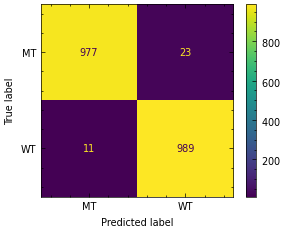

In [6]:
#fig, ax = plt.subplots()
plot_confusion_matrix(forest, np.concatenate([X_CONT, X_PC, X_DISC], axis=1), np.array(df_test['cluster']))
#fig.set_size_inches(6 / 2.54, 6 / 2.54)
plt.show()
#plt.savefig(r'confusion.svg', format='svg', dpi=450, transparent=True)

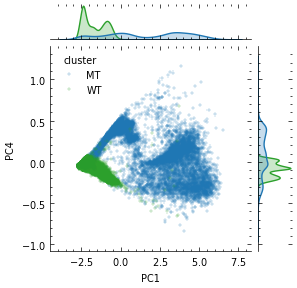

In [7]:
%matplotlib inline
palette = {'NEG': '#ff7f0e', 'MT': '#1f77b4', 'WT':'#2ca02c'}
fig = sns.jointplot(data=df_train.groupby('cluster').sample(10000), x='PC1', y='PC4', hue='cluster', palette=palette, height=3, marker='+', alpha=0.7)
plt.show()
#plt.savefig(r'pc_1_4.svg', format='svg', dpi=450, transparent=True)

In [8]:
def plotAdmix(df, mt_sets, title):
    
    set_df = pd.DataFrame({'set':[], 'mt_af':[], 'allele':[], 'conc':[]})

    for set in df['set'].unique():
        if set.startswith('WT'):
            plt.scatter(0, get_concentration_estimate(len(df.loc[(df['set'] == set) & (df['cluster'] == 'MT')]) / len(df.loc[df['set'] == set]), 5), color='r')
            set_df.loc[len(set_df.index)] = [set, 0, 'MT', get_concentration_estimate(len(df.loc[(df['set'] == set) & (df['cluster'] == 'MT')]) / len(df.loc[df['set'] == set]), 5)]
        elif set in mt_sets:
            plt.scatter(100, get_concentration_estimate(len(df.loc[(df['set'] == set) & (df['cluster'] == 'MT')]) / len(df.loc[df['set'] == set]), 5), color='r')
            print(len(df.loc[(df['set'] == set) & (df['cluster'] == 'MT')]) / len(df.loc[df['set'] == set]), 5)
            set_df.loc[len(set_df.index)] = [set, 100, 'MT', get_concentration_estimate(len(df.loc[(df['set'] == set) & (df['cluster'] == 'MT')]) / len(df.loc[df['set'] == set]), 5)]
        elif set.startswith('MT_10'):
            plt.scatter(10, get_concentration_estimate(len(df.loc[(df['set'] == set) & (df['cluster'] == 'MT')]) / len(df.loc[df['set'] == set]), 5), color='r')
            set_df.loc[len(set_df.index)] = [set, 10, 'MT', get_concentration_estimate(len(df.loc[(df['set'] == set) & (df['cluster'] == 'MT')]) / len(df.loc[df['set'] == set]), 5)]
        elif set.startswith('MT_25'):
            plt.scatter(25, get_concentration_estimate(len(df.loc[(df['set'] == set) & (df['cluster'] == 'MT')]) / len(df.loc[df['set'] == set]), 5), color='r')
            set_df.loc[len(set_df.index)] = [set, 25, 'MT', get_concentration_estimate(len(df.loc[(df['set'] == set) & (df['cluster'] == 'MT')]) / len(df.loc[df['set'] == set]), 5)]
        elif set.startswith('MT_50'):
            plt.scatter(50, get_concentration_estimate(len(df.loc[(df['set'] == set) & (df['cluster'] == 'MT')]) / len(df.loc[df['set'] == set]), 5), color='r')
            set_df.loc[len(set_df.index)] = [set, 50, 'MT', get_concentration_estimate(len(df.loc[(df['set'] == set) & (df['cluster'] == 'MT')]) / len(df.loc[df['set'] == set]), 5)]
        elif set.startswith('MT_75'):
            plt.scatter(75, get_concentration_estimate(len(df.loc[(df['set'] == set) & (df['cluster'] == 'MT')]) / len(df.loc[df['set'] == set]), 5), color='r')
            set_df.loc[len(set_df.index)] = [set, 75, 'MT', get_concentration_estimate(len(df.loc[(df['set'] == set) & (df['cluster'] == 'MT')]) / len(df.loc[df['set'] == set]), 5)]
        elif set.startswith('MT_90'):
            plt.scatter(90, get_concentration_estimate(len(df.loc[(df['set'] == set) & (df['cluster'] == 'MT')]) / len(df.loc[df['set'] == set]), 5), color='r')
            set_df.loc[len(set_df.index)] = [set, 90, 'MT', get_concentration_estimate(len(df.loc[(df['set'] == set) & (df['cluster'] == 'MT')]) / len(df.loc[df['set'] == set]), 5)]
    
    for set in df['set'].unique():
        if set.startswith('WT'):
            plt.scatter(0, get_concentration_estimate(len(df.loc[(df['set'] == set) & (df['cluster'] == 'WT')]) / len(df.loc[df['set'] == set]), 5), color='b')
            set_df.loc[len(set_df.index)] = [set, 0, 'WT', get_concentration_estimate(len(df.loc[(df['set'] == set) & (df['cluster'] == 'WT')]) / len(df.loc[df['set'] == set]), 5)]
            print(len(df.loc[(df['set'] == set) & (df['cluster'] == 'WT')]) / len(df.loc[df['set'] == set]), 5)
        elif set in mt_sets:
            plt.scatter(100, get_concentration_estimate(len(df.loc[(df['set'] == set) & (df['cluster'] == 'WT')]) / len(df.loc[df['set'] == set]), 5), color='b')
            set_df.loc[len(set_df.index)] = [set, 100, 'WT', get_concentration_estimate(len(df.loc[(df['set'] == set) & (df['cluster'] == 'WT')]) / len(df.loc[df['set'] == set]), 5)]
        elif set.startswith('MT_10'):
            plt.scatter(10, get_concentration_estimate(len(df.loc[(df['set'] == set) & (df['cluster'] == 'WT')]) / len(df.loc[df['set'] == set]), 5), color='b')
            set_df.loc[len(set_df.index)] = [set, 10, 'WT', get_concentration_estimate(len(df.loc[(df['set'] == set) & (df['cluster'] == 'WT')]) / len(df.loc[df['set'] == set]), 5)]
        elif set.startswith('MT_25'):
            plt.scatter(25, get_concentration_estimate(len(df.loc[(df['set'] == set) & (df['cluster'] == 'WT')]) / len(df.loc[df['set'] == set]), 5), color='b')
            set_df.loc[len(set_df.index)] = [set, 25, 'WT', get_concentration_estimate(len(df.loc[(df['set'] == set) & (df['cluster'] == 'WT')]) / len(df.loc[df['set'] == set]), 5)]
        elif set.startswith('MT_50'):
            plt.scatter(50, get_concentration_estimate(len(df.loc[(df['set'] == set) & (df['cluster'] == 'WT')]) / len(df.loc[df['set'] == set]), 5), color='b')
            set_df.loc[len(set_df.index)] = [set, 50, 'WT', get_concentration_estimate(len(df.loc[(df['set'] == set) & (df['cluster'] == 'WT')]) / len(df.loc[df['set'] == set]), 5)]
        elif set.startswith('MT_75'):
            plt.scatter(75, get_concentration_estimate(len(df.loc[(df['set'] == set) & (df['cluster'] == 'WT')]) / len(df.loc[df['set'] == set]), 5), color='b')
            set_df.loc[len(set_df.index)] = [set, 75, 'WT', get_concentration_estimate(len(df.loc[(df['set'] == set) & (df['cluster'] == 'WT')]) / len(df.loc[df['set'] == set]), 5)]
        elif set.startswith('MT_90'):
            plt.scatter(90, get_concentration_estimate(len(df.loc[(df['set'] == set) & (df['cluster'] == 'WT')]) / len(df.loc[df['set'] == set]), 5), color='b')
            set_df.loc[len(set_df.index)] = [set, 90, 'WT', get_concentration_estimate(len(df.loc[(df['set'] == set) & (df['cluster'] == 'WT')]) / len(df.loc[df['set'] == set]), 5)]
            
    legend_elements_1 = [Patch(facecolor='b', label='wildtype'),
                           Patch(facecolor='r', label='mutant')]
    plt.gca().add_artist(plt.legend(handles=legend_elements_1, loc='upper center'))

    #plt.ylim(0, 10)
    plt.xlabel('mutant AF [%]')
    plt.ylabel('measured allele concentration [fM]')
    plt.title(title)

    fig = plt.gcf()

    return fig, set_df

Range: 336.33000358777764 - 670.2199578603108
#####
[394.21711297]
[20149.87178687]
MT_25_WT_75_24h


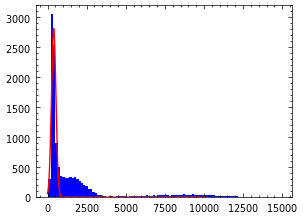

[1.12804058e-071 1.05894921e-018 6.99654981e-051 ... 0.00000000e+000
 4.18224147e-273 6.40226931e-013]
Range: 433.4326690280883 - 825.1919883506415
#####
[532.43203502]
[24870.28698994]
MT_50_WT_50_24h


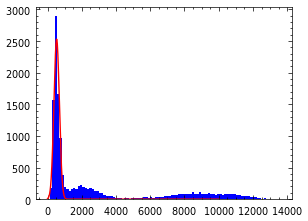

[1.20171543e-007 6.96796218e-087 3.54790231e-058 ... 1.09932842e-057
 5.60338813e-067 2.55467748e-100]
Range: 1539.1543366027292 - 2804.3485336166523
#####
[1779.88542081]
[269675.83821961]
MT_75_WT_25_24h


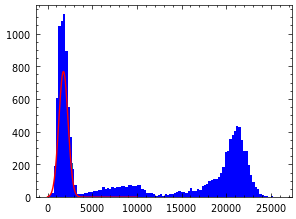

[0.00000000e+000 0.00000000e+000 2.32600511e-099 ... 2.34920233e-014
 3.16180522e-210 2.10124669e-114]
Range: 1466.4006350175637 - 2777.380970487232
#####
[1855.49740903]
[292719.106729]
MT_90_WT_10_24h


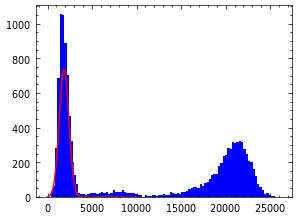

[6.15743979e-036 0.00000000e+000 0.00000000e+000 ... 0.00000000e+000
 6.32156183e-137 0.00000000e+000]
       index  Unnamed: 0    UID            y            x  time  \
0        660        8592    661   190.521739   478.217391   120   
1        661        8605    662   190.468085   502.276596   120   
2        720        9372    721   197.653061   490.265306   120   
3        721        9385    722   197.437500   514.854167   120   
4        735        9567    736   198.590909  1425.113636   120   
...      ...         ...    ...          ...          ...   ...   
52708  15336      199380  66212  1884.238095   209.047619   120   
52709  15337      199393  66213  1887.843137  1167.117647   120   
52710  15338      199406  66214  1887.958333  1307.395833   120   
52711  15339      199419  66215  1888.000000  1377.122449   120   
52712  15343      199471  66219  1894.040000  1061.940000   120   

       feat_fq_initial  feat_rox_initial  feat_fq_delta_final  \
0          9105.573563     

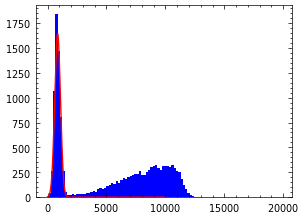

[5.24097405e-009 2.20403863e-208 0.00000000e+000 ... 0.00000000e+000
 0.00000000e+000 0.00000000e+000]
Range: 379.53562047971155 - 771.0565763429929
#####
[404.06157094]
[12687.09496413]
MT_10_WT_90


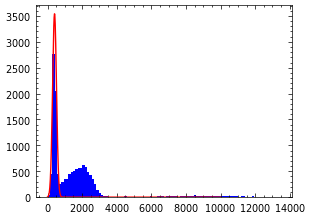

[0.0000000e+000 0.0000000e+000 0.0000000e+000 ... 0.0000000e+000
 0.0000000e+000 1.1205309e-203]
Range: 519.9416172578206 - 1247.8598814187694
#####
[612.57098714]
[32817.64652689]
MT_25_WT_75


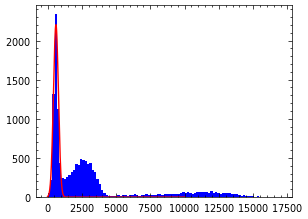

[0.00000000e+000 2.24797876e-016 4.57587123e-074 ... 4.18545878e-013
 3.48063308e-065 1.77966169e-131]
Range: 715.0407356722845 - 1409.546053311281
#####
[732.73886442]
[30914.16330369]
MT_75_WT_25


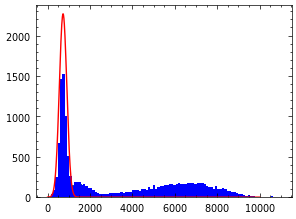

[0.00000000e+000 0.00000000e+000 1.14417166e-130 ... 4.52558263e-088
 0.00000000e+000 0.00000000e+000]
Range: 747.968656092921 - 1710.8933131947815
#####
[827.95573267]
[73365.61190466]
MT_90_WT_10


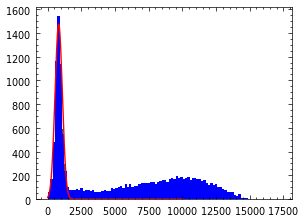

[0.         0.         0.         ... 0.         0.00996943 0.        ]
Range: 451.8147999935751 - 842.1058825412165
#####
[437.5440485]
[4834.99004199]
WT


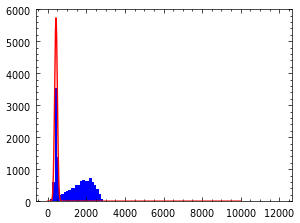

[3.51167703e-082 4.57461722e-142 1.57350634e-145 ... 0.00000000e+000
 5.06981137e-012 6.55556874e-004]
       index  Unnamed: 0     UID            y            x  time  \
0        571        7435     572   168.926829   855.219512   120   
1        573        7461     574   168.936709  1062.493671   120   
2        577        7513     578   169.387500   440.550000   120   
3        578        7526     579   169.212500   647.575000   120   
4        579        7539     580   169.658537   879.487805   120   
...      ...         ...     ...          ...          ...   ...   
84915  17483      227291  108214  1874.144928  1489.985507   120   
84916  17484      227304  108215  1874.029851  1514.164179   120   
84917  17485      227317  108216  1874.059701  1538.656716   120   
84918  17486      227330  108217  1873.833333  1562.878788   120   
84919  17487      227343  108218  1873.645161  1586.983871   120   

       feat_fq_initial  feat_rox_initial  feat_fq_delta_final  \
0          8347

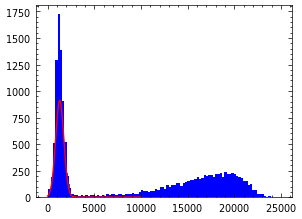

[0.00000000e+000 0.00000000e+000 5.87905019e-135 ... 0.00000000e+000
 0.00000000e+000 0.00000000e+000]
Range: 698.1488709847519 - 1382.3347645498086
#####
[799.34311215]
[51013.58817897]
MT_10_WT_90


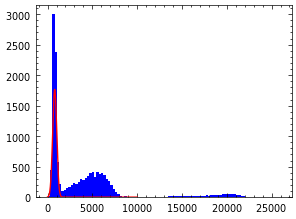

[0.00000000e+00 1.33631118e-34 0.00000000e+00 ... 9.05203395e-87
 0.00000000e+00 2.73560276e-34]
Range: 880.1828544512093 - 1716.0264922504803
#####
[982.30813024]
[82166.36389785]
MT_25_WT_75


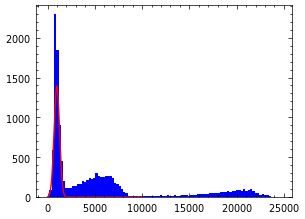

[1.69036708e-034 1.63908096e-083 0.00000000e+000 ... 0.00000000e+000
 4.29751043e-029 4.78402774e-219]
Range: 1157.9316632749023 - 2358.0309284972254
#####
[1197.18805486]
[105290.22205609]
MT_75_WT_25


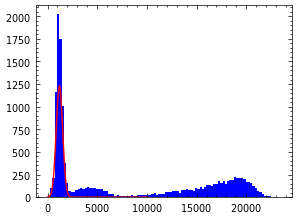

[1.12844168e-010 0.00000000e+000 0.00000000e+000 ... 3.41263814e-005
 0.00000000e+000 6.52207346e-161]
Range: 1291.0552553309878 - 2598.3468186438367
#####
[1321.77222196]
[137046.86807338]
MT_90_WT_10


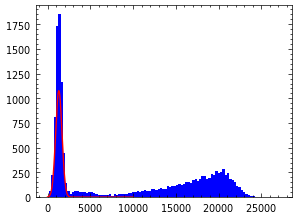

[0.00000000e+000 0.00000000e+000 0.00000000e+000 ... 8.87004412e-158
 1.89337743e-291 0.00000000e+000]
Range: 588.4224953061143 - 1121.6306669161377
#####
[602.13989914]
[17260.45112254]
WT


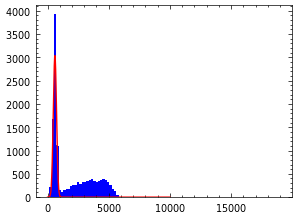

[5.80506113e-078 3.48380628e-033 6.80993852e-241 ... 0.00000000e+000
 0.00000000e+000 2.43215538e-083]
       index  Unnamed: 0     UID            y            x  time  \
0        294        3834     295   166.608108   430.824324   120   
1        295        3847     296   166.467532   674.948052   120   
2        296        3860     297   167.113924   809.126582   120   
3        298        3886     299   167.342466   321.232877   120   
4        299        3899     300   167.260274   565.082192   120   
...      ...         ...     ...          ...          ...   ...   
85325  17435      226667  108671  1762.435897  1206.448718   120   
85326  17436      226680  108672  1762.589744  1230.794872   120   
85327  17438      226706  108674  1762.297297  1656.054054   120   
85328  17439      226719  108675  1762.848101  1680.405063   120   
85329  17440      226732  108676  1762.833333  1704.589744   120   

       feat_fq_initial  feat_rox_initial  feat_fq_delta_final  \
0          8644

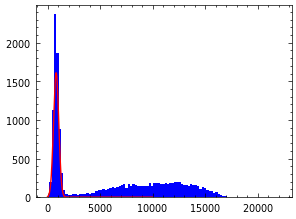

[0.00000000e+000 0.00000000e+000 1.28826151e-051 ... 4.61361549e-041
 3.56626364e-115 0.00000000e+000]
Range: 871.3415616182992 - 1604.1770790109408
#####
[930.24838752]
[58247.220442]
MT_50_WT_50_1


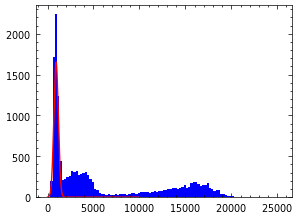

[0.00000000e+000 0.00000000e+000 2.60658192e-152 ... 8.84365786e-031
 0.00000000e+000 3.98305411e-128]
Range: 439.9030137579658 - 1055.767233019118
#####
[449.7446762]
[25545.19125892]
MT_50_WT_50_2


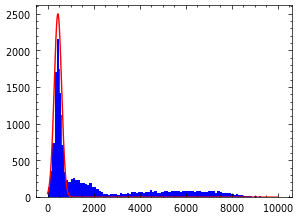

[4.24240201e-66 8.46659888e-43 2.10707996e-15 ... 0.00000000e+00
 0.00000000e+00 5.67200538e-23]
       index  Unnamed: 0    UID            y            x  time  \
0        187        2443    188   161.195402   440.942529   120   
1        188        2456    189   161.136364   599.318182   120   
2        189        2469    190   161.170455   757.886364   120   
3        191        2495    192   162.220930   465.220930   120   
4        192        2508    193   162.183908   623.747126   120   
...      ...         ...    ...          ...          ...   ...   
43660  17488      227356  54696  1826.864198  1156.407407   120   
43661  17489      227369  54697  1826.324324  1606.837838   120   
43662  17490      227382  54698  1826.662162  1631.108108   120   
43663  17491      227395  54699  1827.013158  1655.684211   120   
43664  17500      227512  54708  1827.073529  1679.808824   120   

       feat_fq_initial  feat_rox_initial  feat_fq_delta_final  \
0          8405.078270       5552

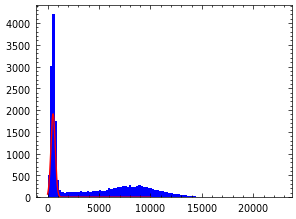

[0.00000000e+00 0.00000000e+00 6.18217088e-18 ... 9.80731661e-31
 1.33838503e-38 4.41766165e-57]
Range: 429.7394882823123 - 849.4850349766639
#####
[523.24647772]
[29566.23703693]
MT_2


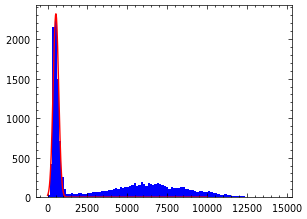

[3.67916645e-61 3.02321237e-13 0.00000000e+00 ... 0.00000000e+00
 3.91183798e-47 0.00000000e+00]
Range: 279.83543794118424 - 573.6626477794277
#####
[356.87231393]
[16124.58735717]
MT_50_WT_50


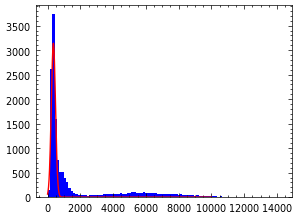

[0.00000000e+00 2.37111622e-82 1.28030364e-32 ... 5.34029879e-07
 2.50978492e-04 8.19465353e-69]
Range: 409.9651905253132 - 885.9247775742133
#####
[475.68127778]
[34178.76806026]
MT_75_WT_25


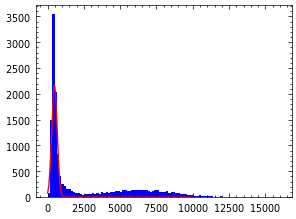

[0.00000000e+00 0.00000000e+00 1.45338000e-19 ... 0.00000000e+00
 1.82293276e-08 0.00000000e+00]
Range: 339.78262391316815 - 773.5051497317415
#####
[412.46250948]
[20817.05485716]
MT_90_WT_10


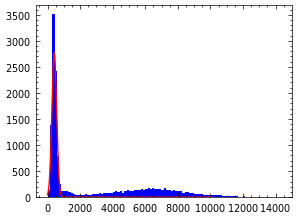

[1.77719478e-06 0.00000000e+00 1.00240467e-94 ... 1.78764343e-47
 4.79964583e-16 0.00000000e+00]
Range: 134.69834458693572 - 323.2760270086457
#####
[137.20247385]
[5096.7521156]
WT


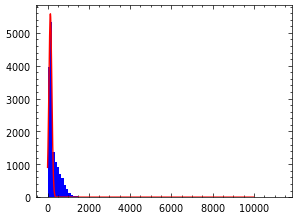

[4.89851037e-004 7.81467235e-003 5.08000426e-276 ... 3.06191276e-002
 8.94393681e-009 1.04566923e-002]
       index  Unnamed: 0     UID            y            x  time  \
0        691        8995     692   225.729730   665.513514   120   
1        700        9112     701   226.027027   689.594595   120   
2        701        9125     702   226.414634   714.121951   120   
3        702        9138     703   226.755556   738.488889   120   
4        703        9151     704   227.159091   762.727273   120   
...      ...         ...     ...          ...          ...   ...   
92326  18129      235689  117465  1814.602740   502.205479   120   
92327  18130      235702  117466  1814.750000   660.411765   120   
92328  18131      235715  117467  1814.214286   794.228571   120   
92329  18132      235728  117468  1814.533333   952.786667   120   
92330  18135      235767  117471  1814.463768  1561.608696   120   

       feat_fq_initial  feat_rox_initial  feat_fq_delta_final  \
0          8369

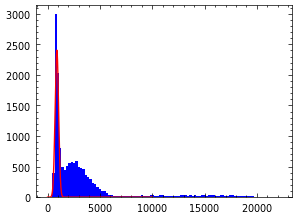

[0.00000000e+00 4.38680667e-71 4.04705141e-77 ... 0.00000000e+00
 0.00000000e+00 6.65011982e-66]
Range: 558.9245615924655 - 944.5226019646905
#####
[574.28156042]
[6014.65594158]
WT_new


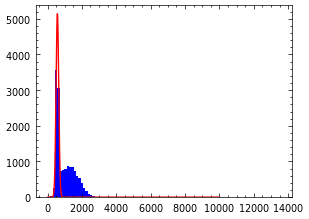

[6.08456001e-06 6.34633201e-04 0.00000000e+00 ... 1.33970541e-17
 2.03700069e-04 0.00000000e+00]
       index  Unnamed: 0    UID            y            x  time  \
0        448        5836    449   166.885417   557.927083   120   
1        449        5849    450   167.051020   582.102041   120   
2        452        5888    453   166.840426  1275.670213   120   
3        453        5901    454   167.322581   606.225806   120   
4        454        5914    455   167.500000   630.695652   120   
...      ...         ...    ...          ...          ...   ...   
29574  18077      235013  36956  1885.101449  1636.971014   120   
29575  18078      235026  36957  1886.095890  1661.438356   120   
29576  18079      235039  36958  1885.342105  1819.184211   120   
29577  18080      235052  36959  1886.229730  1843.500000   120   
29578  18088      235156  36967  1886.178082  1478.767123   120   

       feat_fq_initial  feat_rox_initial  feat_fq_delta_final  \
0          8426.963881       7817

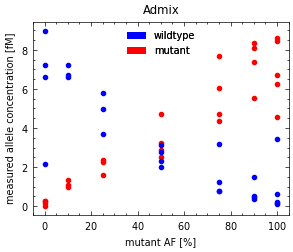

In [16]:
admix_df_list = []

for folder in os.listdir(PATH_ADMIX):
    
    df_admix = batch_load_and_combine(PATH_ADMIX / folder, 'features_{}.csv'.format(CLASSIFY_FRAME_15h))
    df_admix, X_pc_admix = processKinetics(df_admix, forest, scaler, pca, FEATURES_NORM, FEATURES_ORIG, NEG_PROB_CUTOFF)
    plt.clf()
    df_admix['set'] = df_admix['set'] + f'_{folder[4:folder.find("_")]}'
    admix_df_list.append(df_admix)

df_admix_all = pd.concat(admix_df_list)

fig, set_df = plotAdmix(df_admix_all, ['MT_1_0428', 'MT_2_0428', 'MT_0424', 'MT_0425', 'MT_0426'], 'Admix')
plt.show()

In [17]:
set_df['experiment'] = [set[set.rfind('_')+1:] for set in set_df['set']]
set_df

,set,mt_af,allele,conc,experiment
0,MT_25_WT_75_24h_0305,25,MT,1.621137,0305
1,MT_50_WT_50_24h_0305,50,MT,3.255818,0305
2,MT_75_WT_25_24h_0305,75,MT,7.687143,0305
3,MT_90_WT_10_24h_0305,90,MT,8.340745,0305
4,MT_0424,100,MT,4.556114,0424
5,MT_10_WT_90_0424,10,MT,1.077545,0424
6,MT_25_WT_75_0424,25,MT,2.273906,0424
7,MT_75_WT_25_0424,75,MT,4.354879,0424
8,MT_90_WT_10_0424,90,MT,7.365901,0424
9,WT_0424,0,MT,0.280381,0424


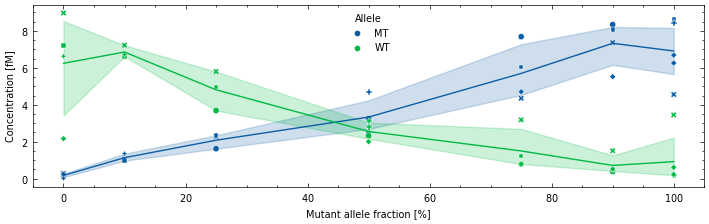

In [18]:
fig, ax = plt.subplots()
sns.lineplot(set_df.loc[set_df['allele'] == 'MT'], x='mt_af', y='conc')
sns.lineplot(set_df.loc[set_df['allele'] == 'WT'], x='mt_af', y='conc')
g=sns.scatterplot(set_df, x='mt_af', y='conc', hue='allele', style='experiment', s=(20.0))
h,l = g.get_legend_handles_labels()
plt.legend(h[1:3],l[1:3], title='Allele', loc='upper center')
plt.xlabel('Mutant allele fraction [%]')
plt.ylabel('Concentration [fM]')
fig.set_size_inches(22 / 2.54, 6 / 2.54)
plt.show()
#plt.savefig(r'Admix_scaled.svg', format='svg', dpi=450, transparent=True)